<a href="https://colab.research.google.com/github/sumeet/chess-deep-learning/blob/main/chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

# Input and outputs

In [ ]:
try:
    from chess import pgn
except ImportError:    
    !pip install python-chess
    import chess
    from chess import pgn

import torch
import torch.nn.functional as F
from torch import tensor

import numpy as np
import gzip


PIECES_ORDER = ['pawn', 'knight', 'bishop', 'rook', 'queen', 'king']  # Chess piece types
PIECES = {name: i for i, name in enumerate(PIECES_ORDER)}

def board_to_tensors(board):
    tensor_board = torch.zeros((12, 8, 8), dtype=torch.float16)

    # Loop through all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Get piece type and color
            piece_type = chess.piece_name(piece.piece_type)
            color = piece.color

            # Calculate the coordinates
            row = square // 8
            col = square % 8

            # Calculate the depth index based on the piece type and color
            piece_index = PIECES[piece_type] + (6 if color == chess.BLACK else 0)

            # Place the piece in the tensor
            tensor_board[piece_index, row, col] = 1

    tensor_extras = torch.zeros(7, dtype=torch.float16)
    # Append castling rights
    tensor_extras[0] = int(board.has_kingside_castling_rights(chess.WHITE))
    tensor_extras[1] = int(board.has_queenside_castling_rights(chess.WHITE))
    tensor_extras[2] = int(board.has_kingside_castling_rights(chess.BLACK))
    tensor_extras[3] = int(board.has_queenside_castling_rights(chess.BLACK))

    # Append en passant square
    if board.ep_square is not None:
        tensor_extras[4] = board.ep_square
    else:
        tensor_extras[4] = 64

    # Append white's turn
    tensor_extras[5] = 1 if board.turn == chess.WHITE else 0

    # Append is in check
    tensor_extras[6] = 0 if board.is_check() else -1

    return (tensor_board, tensor_extras)

f = gzip.open('./drive/MyDrive/MLchess/output.chess.gz', 'rb')
cache = {}
for i, src_file in enumerate('abcdefgh'):
    for j, src_rank in enumerate('12345678'):
        for k, dst_file in enumerate('abcdefgh'):
            for l, dst_rank in enumerate('12345678'):
                for piece_name in PIECES_ORDER:
                    # 128 for the board (8*8*2), 6 for the piece
                    t = torch.zeros(128+6, dtype=torch.float16)
                    src_index = i*8+j
                    dst_index = k*8+l
                    src_move = src_file + src_rank 
                    dst_move = dst_file + dst_rank
                    t[src_index] = 1.
                    t[64+dst_index] = 1.
                    piece_index = PIECES[piece_name]
                    t[128+piece_index] = 1.
                    cache[src_move+dst_move+piece_name] = t

def move_to_tensor(board_after: chess.Board, move: chess.Move):
    piece_name = chess.piece_name(board_after.piece_type_at(move.to_square))
    return cache[move.uci()[:4] + piece_name]


input_board_tensors = []
input_extras_tensors = []
output_tensors = []
num_games = 0

for line in f:
    moves = line.split(b",")
    winner = next(f).strip()
    if winner == b"D":
        continue

    to_move = b"W"

    board = chess.Board()
    for (i, move_san) in enumerate(moves):
        move_san = move_san.strip()

        # (was made by winner)
        use_as_input = to_move == winner and i < len(moves)

        if use_as_input:
            b, e = board_to_tensors(board)
            input_board_tensors.append(b)
            input_extras_tensors.append(e)

        move = board.push_san(move_san.decode('utf-8'))

        if use_as_input:
            output_tensors.append(move_to_tensor(board, move))

        to_move = b"W" if to_move == b"B" else b"B"

    num_games += 1

    if num_games % 1000 == 0:
        print(f'processed {num_games} games already')

    if num_games >= 100_000:
        break


print(f'loaded {len(input_board_tensors)} input  total')

    
training_size = 100_000
training_size = len(input_board_tensors)
input_board_batch = torch.stack(input_board_tensors[:training_size])
input_extras_batch = torch.stack(input_extras_tensors[:training_size])
output_batch = torch.stack(output_tensors[:training_size])
# output_src_batch = torch.stack(output_src_tensors[:training_size])
# output_dst_batch = torch.stack(output_dst_tensors[:training_size])

# test_input = torch.stack(input_sequences[training_size:])
# test_output = torch.stack(output_sequences[training_size:])



processed 1000 games already
processed 2000 games already
processed 3000 games already
processed 4000 games already
processed 5000 games already
processed 6000 games already
processed 7000 games already


# Save input/output tensors to filesystem

In [ ]:
torch.save(input_board_batch, './drive/MyDrive/MLchess/input_board_tensor.pt')
torch.save(input_extras_batch, './drive/MyDrive/MLchess/input_extras_tensor.pt')
torch.save(output_batch, './drive/MyDrive/MLchess/output_tensor.pt')

# Load input/output tensors from filesystem

In [ ]:
input_board_batch = torch.load('./drive/MyDrive/MLchess/input_board_tensor.pt')
input_extras_batch = torch.load('./drive/MyDrive/MLchess/input_extras_tensor.pt')
output_batch = torch.load('./drive/MyDrive/MLchess/output_tensor.pt')

# Define Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class ChessMovePredictor(nn.Module):
    def __init__(self):
        super(ChessMovePredictor, self).__init__()
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # 128*8*8 is the size of the flattened conv layer output,
        # and 7 is the size of the extra features tensor
        self.fc1 = nn.Linear(128*8*8 + 7, 512)  
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(512, 128+6)

    def forward(self, board_tensor, extra_features):
        out = F.relu(self.conv1(board_tensor))
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1)  # Flatten tensor
        out = torch.cat((out, extra_features), dim=1)  # Concatenate extra features
        out = self.relu(self.fc1(out))
        out = self.fc_out(out)
        return out

model = ChessMovePredictor()
if 0:
    filename = './drive/MyDrive/MLchess/checkpoint.pt'
    model.load_state_dict(torch.load(filename))
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train Neural Network

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import time

num_epochs = 1_000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

dataset = TensorDataset(input_board_batch, input_extras_batch, output_batch)
dataloader = DataLoader(dataset, batch_size=1_000, shuffle=False)

for epoch in range(num_epochs):
    epoch_start = time.time()

    for inputs_board, inputs_extras, targets in dataloader:
        inputs_board = inputs_board.to(device)
        inputs_extras = inputs_extras.to(device)
        targets = targets.to(device)
    
        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(inputs_board, inputs_extras)
    
            targets_source, targets_dest, targets_square = targets[:, :64], targets[:, 64:128], targets[:, 128:]
            outputs_source, outputs_dest, outputs_square = outputs[:, :64], outputs[:, 64:128], outputs[:, 128:]
            loss_source = loss_fn(outputs_source, targets_source)
            loss_dest = loss_fn(outputs_dest, targets_dest)
            loss_square = loss_fn(outputs_square, targets_square)
    
    
            # Compute total loss
            loss = loss_source + loss_dest + (loss_square*2)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

    if epoch % 50 == 0:
        filename = './drive/MyDrive/MLchess/checkpoint.pt'
        print(f'saving checkpoint to {filename}')
        torch.save(model.state_dict(), filename)  # Save the model checkpoint

    time_elapsed = time.time() - epoch_start
    print('Epoch [{}/{}], Loss: {:.4f} ({} seconds)'.format(epoch+1, num_epochs, loss.item(), time_elapsed))


# Play with AI

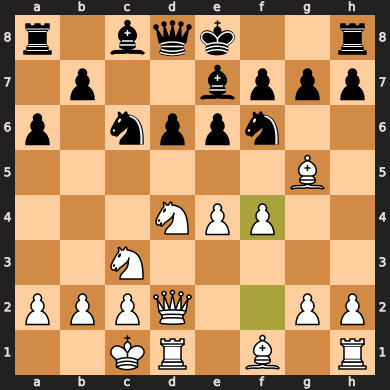

AI's turn
f6e7 knight


IllegalMoveError: ignored

In [39]:
from IPython.display import display, clear_output
#device = torch.device("cpu")
device = torch.device("cuda:0")

def output_to_move(output):
    source_output, dest_output, piece_output = output[:, :64], output[:, 64:128], output[:, 128:]

    # Get the index of the highest value in each half
    source_square_index = torch.argmax(source_output).item()
    dest_square_index = torch.argmax(dest_output).item()
    piece_index = torch.argmax(piece_output).item()
    
    # Convert the indices back into file and rank
    source_file = 'abcdefgh'[source_square_index // 8]
    source_rank = '12345678'[source_square_index % 8]
    dest_file = 'abcdefgh'[dest_square_index // 8]
    dest_rank = '12345678'[dest_square_index % 8]

    # Return the move as a string
    return PIECES_ORDER[piece_index], source_file + source_rank + dest_file + dest_rank


if 0:
    board = chess.Board()

def play(our_move):
    clear_output(wait=True)
    display(board)

    board.push_san(our_move)
    clear_output(wait=True)
    display(board)

    print("AI's turn")

    # Convert board state to model input
    input_tensor, input_extras = board_to_tensors(board)
    input_tensor = input_tensor.unsqueeze(0)
    input_extras = input_extras.unsqueeze(0)

    # Get the move from the model
    # source_output, dest_output = model(input_tensor.to(device), input_extras.to(device))
    output = model(input_tensor.to(device), input_extras.to(device))

    # Convert model output to move
    piece, ai_move = output_to_move(output)
    print(ai_move, piece)
        
    # Make the move on the board
    board.push_san(ai_move)

    clear_output(wait=True)
    display(board)
    print('AI move', ai_move, piece)


play('f2f4')

# Free up memory

In [ ]:
try:
    del dataset
    del dataloader
    del input_batch
    del output_batch
except NameError:
    pass
torch.cuda.empty_cache()

input = test_input.to(device)
output = model(input)
loss_fn(output, test_output.to(device))


tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward0>)